In [17]:
import glob
import matplotlib.pyplot as plt
import mne
import numpy as np
import pyxdf

In [18]:
# load baseline file names
baseline_list = []
path = 'data/**/*S001*.xdf'
for file in glob.glob(path, recursive=True):
    baseline_list.append(file)

baseline_list = [baseline_list[0]]
print(baseline_list)

['data/gme2022/sub-Tobias/ses-S001/eeg/sub-Tobias_ses-S001_task-Default_run-001_eeg.xdf']


In [19]:
# load experiment file names
experiment_list = []
path = 'data/**/*S002*.xdf'
for file in glob.glob(path, recursive=True):
    experiment_list.append(file)
experiment_list = [experiment_list[0]]
print(experiment_list)


['data/gme2022/sub-Tobias/ses-S002/eeg/sub-Tobias_ses-S002_task-Default_run-001_eeg.xdf']


In [20]:
# read baseline and cut it to 40 sec
sfreq = 250
info = mne.create_info(8, sfreq, ["eeg"] * 8)

baseline_mne_list = []
for baseline in baseline_list:
    streams, _ = pyxdf.load_xdf(baseline)
    try:
        data = streams[1]["time_series"].T[:8]
    except AttributeError:
        # some recordings miss the marker channel
        data = streams[0]["time_series"].T[:8]
    raw = mne.io.RawArray(data, info, verbose=False)
    raw = raw.crop(tmin=1, tmax=41)
    baseline_mne_list.append(raw)

In [21]:
# read trials

trials = { 
          'ball': list(),
          'ball+number': list(),
          'ball+number+wheel': list(),
          'baseline': baseline_mne_list
         }

for experiment in experiment_list:
    print(experiment)
    streams, _ = pyxdf.load_xdf(experiment)
    marker = -1 
    eeg = -1
    for idx, stream in enumerate(streams):
        if streams[idx]['time_stamps'].shape[0] == 0:
            # ignore empty streams
            continue
        if stream["info"]["name"] == ["markers"]:
            marker = idx
        elif stream["info"]["name"] == ["eeg"]:
            eeg = idx
        else:
            raise Exception(f"stream info name unknown {stream['info']['name']}")

    if marker == -1 and eeg == -1:
        raise Exception('channels not found')    
    
    for i in range(0, streams[marker]["time_stamps"].shape[0], 2):
        event = streams[marker]["time_series"][i][0]
        if event in ['Starting Complex Eye Tracking Dashboard', 'Starting Simple Eye Tracking Dashboard', '']:
            print(f"Skip event {event}")
            continue
        start = streams[marker]["time_stamps"][i]
        stop = streams[marker]["time_stamps"][i+1]
        print(start, stop, event)

        data = []
        for j, stamp in enumerate(streams[eeg]["time_stamps"]):
            if start <= stamp and stamp <= stop: 
                data.append(streams[eeg]["time_series"][j])
        data = np.array(data).T[:8]
        print(data)

        trial = mne.io.RawArray(data, info, verbose=False)
        
        # match event:
        #     case 'Starting Cognitive Load Tasks: Balls True, Numbers False, Wheel False':
        #         key = 'ball'
        #     case 'Starting Cognitive Load Tasks: Balls True, Numbers True, Wheel False':
        #         key = 'ball+number'
        #     case 'Starting Cognitive Load Tasks: Balls True, Numbers True, Wheel True':
        #         key = 'ball+number+wheel'
        #     case _:
        #         print(f"key {event} not defined!")

        if event == 'Starting Cognitive Load Tasks: Balls True, Numbers False, Wheel False':
            key = 'ball'
        elif event == 'Starting Cognitive Load Tasks: Balls True, Numbers True, Wheel False':
            key = 'ball+number'
        elif event == 'Starting Cognitive Load Tasks: Balls True, Numbers True, Wheel True':
            key = 'ball+number+wheel'
        else:
            print(f"key {event} not defined!")

        trials[key].append(trial)


data/gme2022/sub-Tobias/ses-S002/eeg/sub-Tobias_ses-S002_task-Default_run-001_eeg.xdf
101117.70974713018 101157.71034355162 Starting Cognitive Load Tasks: Balls True, Numbers True, Wheel False
[[216022.38 216105.08 216108.39 ... 216151.3  216091.84 216018.8 ]
 [198330.17 198556.72 198626.73 ... 198618.6  198513.72 198299.6 ]
 [326746.84 327052.44 327197.53 ... 318800.25 318706.03 318406.06]
 ...
 [161717.92 162002.69 162123.73 ... 161991.86 161889.77 161615.81]
 [207227.4  207872.58 208356.17 ... 208290.02 208254.44 207588.97]
 [170204.61 170511.9  170629.47 ... 170156.16 170038.94 169741.39]]
101211.09729437983 101251.10414130123 Starting Cognitive Load Tasks: Balls True, Numbers False, Wheel False
[[215894.34 215823.62 215860.02 ... 215858.23 215889.97 215840.88]
 [198230.03 198021.89 198053.1  ... 198053.   198201.42 198107.81]
 [309447.4  309126.53 309103.2  ... 303920.   304177.12 304101.4 ]
 ...
 [161573.97 161298.33 161304.86 ... 161182.02 161393.45 161306.38]
 [207799.27 207063

Effective window size : 8.192 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
/tmp/ipykernel_1159002/1156392459.py:2: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.plot_psd(tmax=np.inf, fmax=125)


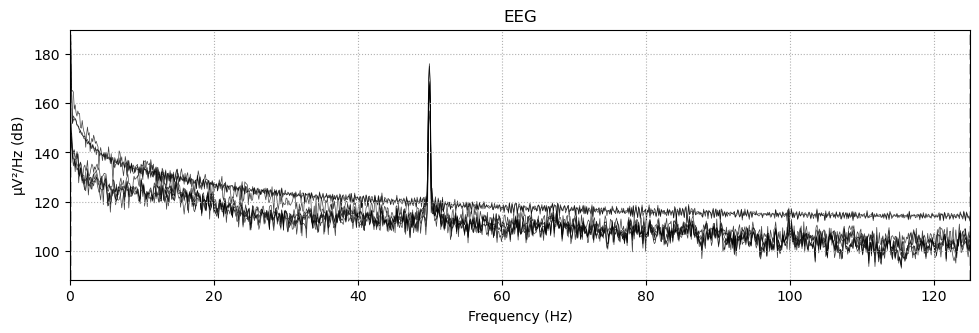

Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1651 samples (6.604 sec)

Effective window size : 8.192 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
/tmp/ipykernel_1159002/1156392459.py:7: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw_notch.plot_psd(tmax=np.inf, fmax=125);


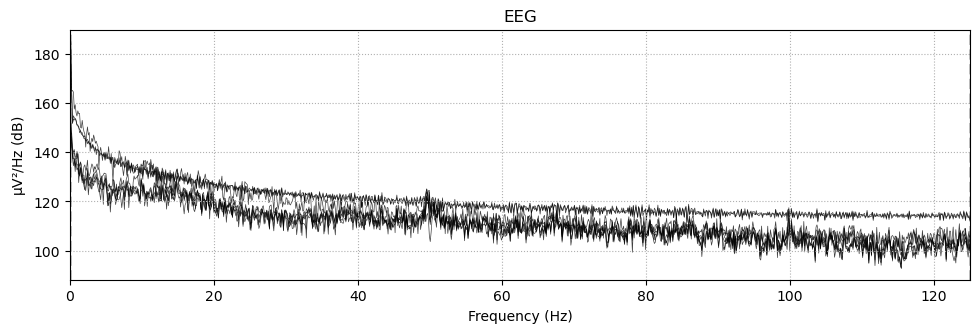

In [22]:
raw = baseline_mne_list[0]
raw.plot_psd(tmax=np.inf, fmax=125)

# filter power line noise
freqs = (50)
raw_notch = raw.copy().notch_filter(freqs=freqs)
raw_notch.plot_psd(tmax=np.inf, fmax=125);


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 4.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 4.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.50 Hz)
- Filter length: 1651 samples (6.604 sec)

Effective window size : 8.192 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
/tmp/ipykernel_1159002/1235651001.py:16: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw_filt.plot_psd(tmax=np.inf, fmin=fmin, fmax=fmax)


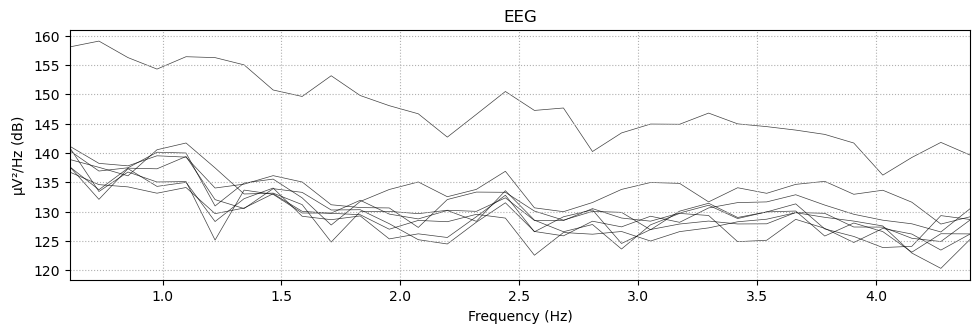

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4.5 - 8.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.50 Hz)
- Upper passband edge: 8.50 Hz
- Upper transition bandwidth: 2.12 Hz (-6 dB cutoff frequency: 9.56 Hz)
- Filter length: 413 samples (1.652 sec)

Effective window size : 8.192 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
/tmp/ipykernel_1159002/1235651001.py:16: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw_filt.plot_psd(tmax=np.inf, fmin=fmin, fmax=fmax)


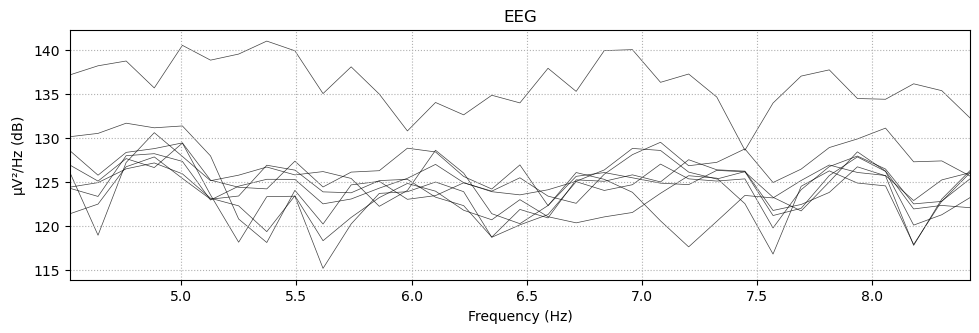

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8.5 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.50
- Lower transition bandwidth: 2.12 Hz (-6 dB cutoff frequency: 7.44 Hz)
- Upper passband edge: 11.50 Hz
- Upper transition bandwidth: 2.88 Hz (-6 dB cutoff frequency: 12.94 Hz)
- Filter length: 389 samples (1.556 sec)

Effective window size : 8.192 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
/tmp/ipykernel_1159002/1235651001.py:16: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw_filt.plot_psd(tmax=np.inf, fmin=fmin, fmax=fmax)


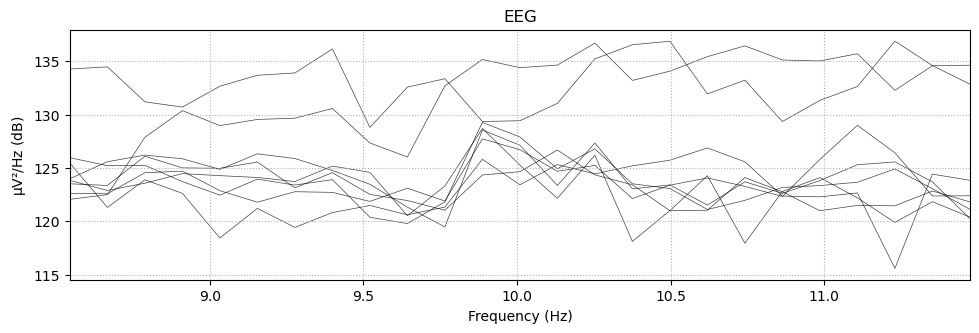

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 12 - 16 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 11.50
- Lower transition bandwidth: 2.88 Hz (-6 dB cutoff frequency: 10.06 Hz)
- Upper passband edge: 15.50 Hz
- Upper transition bandwidth: 3.88 Hz (-6 dB cutoff frequency: 17.44 Hz)
- Filter length: 287 samples (1.148 sec)

Effective window size : 8.192 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
/tmp/ipykernel_1159002/1235651001.py:16: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw_filt.plot_psd(tmax=np.inf, fmin=fmin, fmax=fmax)


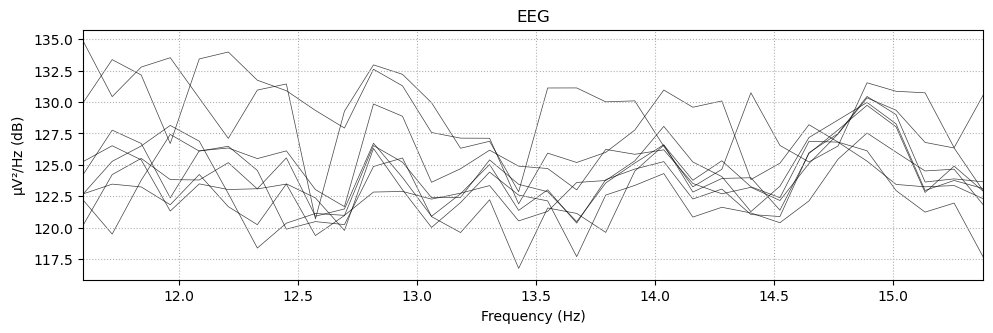

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 16 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.50
- Lower transition bandwidth: 3.88 Hz (-6 dB cutoff frequency: 13.56 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 213 samples (0.852 sec)

Effective window size : 8.192 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
/tmp/ipykernel_1159002/1235651001.py:16: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw_filt.plot_psd(tmax=np.inf, fmin=fmin, fmax=fmax)


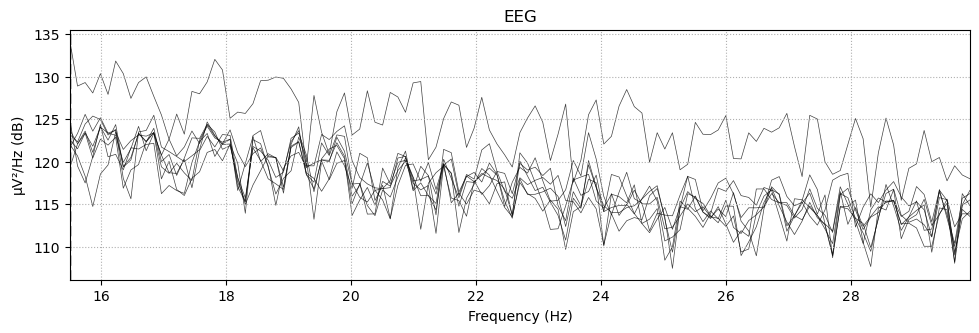

In [23]:
# a first try to print bands for one example file
raw = baseline_mne_list[0]
FREQ_BANDS = {"delta": [0.5, 4.5],
                "theta": [4.5, 8.5],
                "alpha": [8.5, 11.5],
                "sigma": [11.5, 15.5],
                "beta": [15.5, 30]}


for start in range(0, 2, 2):
    raw_crop = raw.copy().crop(tmin=start, tmax=start+2)
    for band, freq in FREQ_BANDS.items():
        fmin, fmax = freq
        raw_filt = raw.copy()
        raw_filt.filter(fmin, fmax, n_jobs=1)
        raw_filt.plot_psd(tmax=np.inf, fmin=fmin, fmax=fmax)

In [24]:
from mne.time_frequency import psd_welch

def eeg_power_band(raw: mne.io.RawArray):
    """EEG relative power band feature extraction.

    This function takes an ``mne.io.RawArray`` object and creates EEG features based
    on relative power in specific frequency bands that are compatible with
    scikit-learn.

    Parameters
    ----------
    raw : RawArray
        The data.

    Returns
    -------
    X : numpy array of shape [n_samples, 5]
        Transformed data.
    """

    # specific frequency bands
    FREQ_BANDS = {"delta": [0.5, 4.5],
                  "theta": [4.5, 8.5],
                  "alpha": [8.5, 11.5],
                  "sigma": [11.5, 15.5],
                  "beta": [15.5, 30]}

    psds, freqs = psd_welch(raw, picks='eeg', fmin=0.5, fmax=30., verbose=False)
    # Normalize the PSDs
    psds /= np.sum(psds, axis=-1, keepdims=True)

    X = []
    for fmin, fmax in FREQ_BANDS.values():
        psds_band = psds[:, (freqs >= fmin) & (freqs < fmax)].mean(axis=-1)
        X.append(psds_band.reshape(len(psds), -1))

    return np.concatenate(X ,axis=-2).squeeze() # concatenate all 8 channels * 5 frequences

In [25]:
# show features
tmp = eeg_power_band(trials['ball'][0])
print(tmp.shape)
tmp


(40,)


array([0.11900077, 0.11157981, 0.22602907, 0.23358879, 0.09924845,
       0.12240937, 0.16182783, 0.1154613 , 0.03893578, 0.03507878,
       0.00705723, 0.00444292, 0.04170134, 0.0393406 , 0.03261823,
       0.03488561, 0.02345952, 0.03421378, 0.00471782, 0.00309751,
       0.02853149, 0.02663818, 0.01934775, 0.02726724, 0.03051583,
       0.03307139, 0.00542614, 0.00390365, 0.03345213, 0.02850964,
       0.01737195, 0.0286684 , 0.01172079, 0.01189592, 0.00211979,
       0.00153107, 0.01445319, 0.01060314, 0.00631231, 0.0134758 ])

In [26]:
def create_ml_data(trails, step=2):
    X = []
    y = []
    for data_type, data_list in trails.items():
        for data in data_list:
            for start in range(0, int(data.tmax), step):
                raw_crop = data.copy().crop(tmin=start, tmax=start+2)
                X.append(eeg_power_band(raw_crop))
                y.append(data_type)
    return X, y

X, y = create_ml_data(trials)

print(X[:1], len(X)) # 8 channels * 5 values
print(y[:1], len(y))


[array([0.06962631, 0.04454465, 0.20675816, 0.22400501, 0.07842905,
       0.13153945, 0.11539369, 0.09068048, 0.06847077, 0.04284214,
       0.01392297, 0.01017418, 0.01878663, 0.01246   , 0.03852923,
       0.01908215, 0.0638151 , 0.09165084, 0.01230289, 0.00352272,
       0.04254642, 0.02255495, 0.03360705, 0.03660979, 0.01632348,
       0.02403406, 0.00760886, 0.0065097 , 0.04280955, 0.03255957,
       0.02849365, 0.04861307, 0.01272483, 0.01862427, 0.00332876,
       0.00177842, 0.02081732, 0.01507327, 0.01130084, 0.01711119])] 200
['ball'] 200


In [27]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

pipe = make_pipeline(RandomForestClassifier(n_estimators=100, random_state=42))

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Train
pipe.fit(X_train, y_train)

# Test
y_pred = pipe.predict(X_test)

# Assess the results
acc = accuracy_score(y_test, y_pred)

print("Accuracy score: {}".format(acc))
print(classification_report(y_test, y_pred, target_names=trials.keys()))
print(confusion_matrix(y_test, y_pred))

Accuracy score: 0.52
                   precision    recall  f1-score   support

             ball       0.29      0.42      0.34        12
      ball+number       0.75      0.53      0.62        17
ball+number+wheel       0.53      0.47      0.50        17
         baseline       0.67      1.00      0.80         4

         accuracy                           0.52        50
        macro avg       0.56      0.60      0.57        50
     weighted avg       0.56      0.52      0.53        50

[[5 1 6 0]
 [5 9 1 2]
 [7 2 8 0]
 [0 0 0 4]]


In [28]:
from sklearn.svm import SVC

pipe = make_pipeline(SVC(kernel= 'linear', random_state=42, C=0.1))

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Train
pipe.fit(X_train, y_train)

# Test
y_pred = pipe.predict(X_test)

# Assess the results
acc = accuracy_score(y_test, y_pred)

print("Accuracy score: {}".format(acc))
print(classification_report(y_test, y_pred, target_names=trials.keys()))
print(confusion_matrix(y_test, y_pred))

Accuracy score: 0.24
                   precision    recall  f1-score   support

             ball       0.24      1.00      0.39        12
      ball+number       0.00      0.00      0.00        17
ball+number+wheel       0.00      0.00      0.00        17
         baseline       0.00      0.00      0.00         4

         accuracy                           0.24        50
        macro avg       0.06      0.25      0.10        50
     weighted avg       0.06      0.24      0.09        50

[[12  0  0  0]
 [17  0  0  0]
 [17  0  0  0]
 [ 4  0  0  0]]


/usr/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [29]:
from sklearn.ensemble import GradientBoostingClassifier

pipe = make_pipeline(GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0))

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Train
pipe.fit(X_train, y_train)

# Test
y_pred = pipe.predict(X_test)

# Assess the results
acc = accuracy_score(y_test, y_pred)

print("Accuracy score: {}".format(acc))
print(classification_report(y_test, y_pred, target_names=trials.keys()))
print(confusion_matrix(y_test, y_pred))

Accuracy score: 0.48
                   precision    recall  f1-score   support

             ball       0.28      0.42      0.33        12
      ball+number       0.69      0.53      0.60        17
ball+number+wheel       0.46      0.35      0.40        17
         baseline       0.67      1.00      0.80         4

         accuracy                           0.48        50
        macro avg       0.52      0.57      0.53        50
     weighted avg       0.51      0.48      0.48        50

[[5 1 6 0]
 [5 9 1 2]
 [8 3 6 0]
 [0 0 0 4]]


In [30]:
import xgboost as xgb
from sklearn.model_selection import  GridSearchCV, StratifiedKFold

estimator = xgb.sklearn.XGBClassifier(
    objective='multi:softmax',
    num_class=4,
    eval_metric='logloss',
    tree_method="gpu_hist",
    )

param_grid = {
    'learning_rate': [.1, 0.2, 0.4],  # `eta` value
    'max_depth': [4, 6, 8],
    #'min_child_weight': [1, 3, 5, 10],
    'subsample': [0.7, 1],
    #'colsample_bytree': [0.7, 1],
    'n_estimators': [100, 200, 300],
    'gamma': [0.5, 1, 2]
}

mycv = StratifiedKFold(n_splits=3)

grid = GridSearchCV(
    estimator,
    param_grid,
    refit='accuracy',
    verbose=1,
    scoring=['accuracy'],
    cv=mycv
)


from sklearn import preprocessing
le = preprocessing.LabelEncoder()
y_numeric = le.fit_transform(y)
y_numeric

grid.fit(X, y_numeric)
grid.cv_results_

Fitting 3 folds for each of 162 candidates, totalling 486 fits
[09:04:19] WARNING: ../src/learner.cc:248: No visible GPU is found, setting `gpu_id` to -1
[09:04:19] WARNING: ../src/learner.cc:248: No visible GPU is found, setting `gpu_id` to -1
[09:04:19] WARNING: ../src/learner.cc:248: No visible GPU is found, setting `gpu_id` to -1
[09:04:19] WARNING: ../src/learner.cc:248: No visible GPU is found, setting `gpu_id` to -1
[09:04:19] WARNING: ../src/learner.cc:248: No visible GPU is found, setting `gpu_id` to -1
[09:04:19] WARNING: ../src/learner.cc:248: No visible GPU is found, setting `gpu_id` to -1
[09:04:19] WARNING: ../src/learner.cc:248: No visible GPU is found, setting `gpu_id` to -1
[09:04:19] WARNING: ../src/learner.cc:248: No visible GPU is found, setting `gpu_id` to -1
[09:04:19] WARNING: ../src/learner.cc:248: No visible GPU is found, setting `gpu_id` to -1
[09:04:19] WARNING: ../src/learner.cc:248: No visible GPU is found, setting `gpu_id` to -1
[09:04:19] WARNING: ../src/

ValueError: 
All the 486 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
32 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/weiss/.local/lib/python3.10/site-packages/xgboost/core.py", line 575, in inner_f
    return f(**kwargs)
  File "/home/weiss/.local/lib/python3.10/site-packages/xgboost/sklearn.py", line 1400, in fit
    self._Booster = train(
  File "/home/weiss/.local/lib/python3.10/site-packages/xgboost/core.py", line 575, in inner_f
    return f(**kwargs)
  File "/home/weiss/.local/lib/python3.10/site-packages/xgboost/training.py", line 181, in train
    bst.update(dtrain, i, obj)
  File "/home/weiss/.local/lib/python3.10/site-packages/xgboost/core.py", line 1778, in update
    _check_call(_LIB.XGBoosterUpdateOneIter(self.handle,
  File "/home/weiss/.local/lib/python3.10/site-packages/xgboost/core.py", line 246, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [09:04:19] ../src/gbm/gbtree.cc:597: Check failed: common::AllVisibleGPUs() >= 1 (0 vs. 1) : No visible GPU is found for XGBoost.
Stack trace:
  [bt] (0) /home/weiss/.local/lib/python3.10/site-packages/xgboost/lib/libxgboost.so(+0x1e4459) [0x7f4c59be4459]
  [bt] (1) /home/weiss/.local/lib/python3.10/site-packages/xgboost/lib/libxgboost.so(+0x1e5571) [0x7f4c59be5571]
  [bt] (2) /home/weiss/.local/lib/python3.10/site-packages/xgboost/lib/libxgboost.so(+0x1e595a) [0x7f4c59be595a]
  [bt] (3) /home/weiss/.local/lib/python3.10/site-packages/xgboost/lib/libxgboost.so(+0x225a3d) [0x7f4c59c25a3d]
  [bt] (4) /home/weiss/.local/lib/python3.10/site-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x68) [0x7f4c59abf098]
  [bt] (5) /usr/lib/libffi.so.8(+0x7536) [0x7f4ca5764536]
  [bt] (6) /usr/lib/libffi.so.8(+0x4037) [0x7f4ca5761037]
  [bt] (7) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0x7db8) [0x7f4ca52bfdb8]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0x758a) [0x7f4ca52bf58a]



--------------------------------------------------------------------------------
89 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/weiss/.local/lib/python3.10/site-packages/xgboost/core.py", line 575, in inner_f
    return f(**kwargs)
  File "/home/weiss/.local/lib/python3.10/site-packages/xgboost/sklearn.py", line 1400, in fit
    self._Booster = train(
  File "/home/weiss/.local/lib/python3.10/site-packages/xgboost/core.py", line 575, in inner_f
    return f(**kwargs)
  File "/home/weiss/.local/lib/python3.10/site-packages/xgboost/training.py", line 181, in train
    bst.update(dtrain, i, obj)
  File "/home/weiss/.local/lib/python3.10/site-packages/xgboost/core.py", line 1778, in update
    _check_call(_LIB.XGBoosterUpdateOneIter(self.handle,
  File "/home/weiss/.local/lib/python3.10/site-packages/xgboost/core.py", line 246, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [09:04:20] ../src/gbm/gbtree.cc:597: Check failed: common::AllVisibleGPUs() >= 1 (0 vs. 1) : No visible GPU is found for XGBoost.
Stack trace:
  [bt] (0) /home/weiss/.local/lib/python3.10/site-packages/xgboost/lib/libxgboost.so(+0x1e4459) [0x7f4c59be4459]
  [bt] (1) /home/weiss/.local/lib/python3.10/site-packages/xgboost/lib/libxgboost.so(+0x1e5571) [0x7f4c59be5571]
  [bt] (2) /home/weiss/.local/lib/python3.10/site-packages/xgboost/lib/libxgboost.so(+0x1e595a) [0x7f4c59be595a]
  [bt] (3) /home/weiss/.local/lib/python3.10/site-packages/xgboost/lib/libxgboost.so(+0x225a3d) [0x7f4c59c25a3d]
  [bt] (4) /home/weiss/.local/lib/python3.10/site-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x68) [0x7f4c59abf098]
  [bt] (5) /usr/lib/libffi.so.8(+0x7536) [0x7f4ca5764536]
  [bt] (6) /usr/lib/libffi.so.8(+0x4037) [0x7f4ca5761037]
  [bt] (7) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0x7db8) [0x7f4ca52bfdb8]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0x758a) [0x7f4ca52bf58a]



--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/weiss/.local/lib/python3.10/site-packages/xgboost/core.py", line 575, in inner_f
    return f(**kwargs)
  File "/home/weiss/.local/lib/python3.10/site-packages/xgboost/sklearn.py", line 1400, in fit
    self._Booster = train(
  File "/home/weiss/.local/lib/python3.10/site-packages/xgboost/core.py", line 575, in inner_f
    return f(**kwargs)
  File "/home/weiss/.local/lib/python3.10/site-packages/xgboost/training.py", line 181, in train
    bst.update(dtrain, i, obj)
  File "/home/weiss/.local/lib/python3.10/site-packages/xgboost/core.py", line 1778, in update
    _check_call(_LIB.XGBoosterUpdateOneIter(self.handle,
  File "/home/weiss/.local/lib/python3.10/site-packages/xgboost/core.py", line 246, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [09:04:21] ../src/gbm/gbtree.cc:597: Check failed: common::AllVisibleGPUs() >= 1 (0 vs. 1) : No visible GPU is found for XGBoost.
Stack trace:
  [bt] (0) /home/weiss/.local/lib/python3.10/site-packages/xgboost/lib/libxgboost.so(+0x1e4459) [0x7f4c59be4459]
  [bt] (1) /home/weiss/.local/lib/python3.10/site-packages/xgboost/lib/libxgboost.so(+0x1e5571) [0x7f4c59be5571]
  [bt] (2) /home/weiss/.local/lib/python3.10/site-packages/xgboost/lib/libxgboost.so(+0x1e595a) [0x7f4c59be595a]
  [bt] (3) /home/weiss/.local/lib/python3.10/site-packages/xgboost/lib/libxgboost.so(+0x225a3d) [0x7f4c59c25a3d]
  [bt] (4) /home/weiss/.local/lib/python3.10/site-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x68) [0x7f4c59abf098]
  [bt] (5) /usr/lib/libffi.so.8(+0x7536) [0x7f4ca5764536]
  [bt] (6) /usr/lib/libffi.so.8(+0x4037) [0x7f4ca5761037]
  [bt] (7) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0x7db8) [0x7f4ca52bfdb8]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0x758a) [0x7f4ca52bf58a]



--------------------------------------------------------------------------------
67 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/weiss/.local/lib/python3.10/site-packages/xgboost/core.py", line 575, in inner_f
    return f(**kwargs)
  File "/home/weiss/.local/lib/python3.10/site-packages/xgboost/sklearn.py", line 1400, in fit
    self._Booster = train(
  File "/home/weiss/.local/lib/python3.10/site-packages/xgboost/core.py", line 575, in inner_f
    return f(**kwargs)
  File "/home/weiss/.local/lib/python3.10/site-packages/xgboost/training.py", line 181, in train
    bst.update(dtrain, i, obj)
  File "/home/weiss/.local/lib/python3.10/site-packages/xgboost/core.py", line 1778, in update
    _check_call(_LIB.XGBoosterUpdateOneIter(self.handle,
  File "/home/weiss/.local/lib/python3.10/site-packages/xgboost/core.py", line 246, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [09:04:22] ../src/gbm/gbtree.cc:597: Check failed: common::AllVisibleGPUs() >= 1 (0 vs. 1) : No visible GPU is found for XGBoost.
Stack trace:
  [bt] (0) /home/weiss/.local/lib/python3.10/site-packages/xgboost/lib/libxgboost.so(+0x1e4459) [0x7f4c59be4459]
  [bt] (1) /home/weiss/.local/lib/python3.10/site-packages/xgboost/lib/libxgboost.so(+0x1e5571) [0x7f4c59be5571]
  [bt] (2) /home/weiss/.local/lib/python3.10/site-packages/xgboost/lib/libxgboost.so(+0x1e595a) [0x7f4c59be595a]
  [bt] (3) /home/weiss/.local/lib/python3.10/site-packages/xgboost/lib/libxgboost.so(+0x225a3d) [0x7f4c59c25a3d]
  [bt] (4) /home/weiss/.local/lib/python3.10/site-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x68) [0x7f4c59abf098]
  [bt] (5) /usr/lib/libffi.so.8(+0x7536) [0x7f4ca5764536]
  [bt] (6) /usr/lib/libffi.so.8(+0x4037) [0x7f4ca5761037]
  [bt] (7) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0x7db8) [0x7f4ca52bfdb8]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0x758a) [0x7f4ca52bf58a]



--------------------------------------------------------------------------------
83 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/weiss/.local/lib/python3.10/site-packages/xgboost/core.py", line 575, in inner_f
    return f(**kwargs)
  File "/home/weiss/.local/lib/python3.10/site-packages/xgboost/sklearn.py", line 1400, in fit
    self._Booster = train(
  File "/home/weiss/.local/lib/python3.10/site-packages/xgboost/core.py", line 575, in inner_f
    return f(**kwargs)
  File "/home/weiss/.local/lib/python3.10/site-packages/xgboost/training.py", line 181, in train
    bst.update(dtrain, i, obj)
  File "/home/weiss/.local/lib/python3.10/site-packages/xgboost/core.py", line 1778, in update
    _check_call(_LIB.XGBoosterUpdateOneIter(self.handle,
  File "/home/weiss/.local/lib/python3.10/site-packages/xgboost/core.py", line 246, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [09:04:23] ../src/gbm/gbtree.cc:597: Check failed: common::AllVisibleGPUs() >= 1 (0 vs. 1) : No visible GPU is found for XGBoost.
Stack trace:
  [bt] (0) /home/weiss/.local/lib/python3.10/site-packages/xgboost/lib/libxgboost.so(+0x1e4459) [0x7f4c59be4459]
  [bt] (1) /home/weiss/.local/lib/python3.10/site-packages/xgboost/lib/libxgboost.so(+0x1e5571) [0x7f4c59be5571]
  [bt] (2) /home/weiss/.local/lib/python3.10/site-packages/xgboost/lib/libxgboost.so(+0x1e595a) [0x7f4c59be595a]
  [bt] (3) /home/weiss/.local/lib/python3.10/site-packages/xgboost/lib/libxgboost.so(+0x225a3d) [0x7f4c59c25a3d]
  [bt] (4) /home/weiss/.local/lib/python3.10/site-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x68) [0x7f4c59abf098]
  [bt] (5) /usr/lib/libffi.so.8(+0x7536) [0x7f4ca5764536]
  [bt] (6) /usr/lib/libffi.so.8(+0x4037) [0x7f4ca5761037]
  [bt] (7) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0x7db8) [0x7f4ca52bfdb8]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0x758a) [0x7f4ca52bf58a]



--------------------------------------------------------------------------------
84 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/weiss/.local/lib/python3.10/site-packages/xgboost/core.py", line 575, in inner_f
    return f(**kwargs)
  File "/home/weiss/.local/lib/python3.10/site-packages/xgboost/sklearn.py", line 1400, in fit
    self._Booster = train(
  File "/home/weiss/.local/lib/python3.10/site-packages/xgboost/core.py", line 575, in inner_f
    return f(**kwargs)
  File "/home/weiss/.local/lib/python3.10/site-packages/xgboost/training.py", line 181, in train
    bst.update(dtrain, i, obj)
  File "/home/weiss/.local/lib/python3.10/site-packages/xgboost/core.py", line 1778, in update
    _check_call(_LIB.XGBoosterUpdateOneIter(self.handle,
  File "/home/weiss/.local/lib/python3.10/site-packages/xgboost/core.py", line 246, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [09:04:24] ../src/gbm/gbtree.cc:597: Check failed: common::AllVisibleGPUs() >= 1 (0 vs. 1) : No visible GPU is found for XGBoost.
Stack trace:
  [bt] (0) /home/weiss/.local/lib/python3.10/site-packages/xgboost/lib/libxgboost.so(+0x1e4459) [0x7f4c59be4459]
  [bt] (1) /home/weiss/.local/lib/python3.10/site-packages/xgboost/lib/libxgboost.so(+0x1e5571) [0x7f4c59be5571]
  [bt] (2) /home/weiss/.local/lib/python3.10/site-packages/xgboost/lib/libxgboost.so(+0x1e595a) [0x7f4c59be595a]
  [bt] (3) /home/weiss/.local/lib/python3.10/site-packages/xgboost/lib/libxgboost.so(+0x225a3d) [0x7f4c59c25a3d]
  [bt] (4) /home/weiss/.local/lib/python3.10/site-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x68) [0x7f4c59abf098]
  [bt] (5) /usr/lib/libffi.so.8(+0x7536) [0x7f4ca5764536]
  [bt] (6) /usr/lib/libffi.so.8(+0x4037) [0x7f4ca5761037]
  [bt] (7) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0x7db8) [0x7f4ca52bfdb8]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0x758a) [0x7f4ca52bf58a]



--------------------------------------------------------------------------------
71 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/weiss/.local/lib/python3.10/site-packages/xgboost/core.py", line 575, in inner_f
    return f(**kwargs)
  File "/home/weiss/.local/lib/python3.10/site-packages/xgboost/sklearn.py", line 1400, in fit
    self._Booster = train(
  File "/home/weiss/.local/lib/python3.10/site-packages/xgboost/core.py", line 575, in inner_f
    return f(**kwargs)
  File "/home/weiss/.local/lib/python3.10/site-packages/xgboost/training.py", line 181, in train
    bst.update(dtrain, i, obj)
  File "/home/weiss/.local/lib/python3.10/site-packages/xgboost/core.py", line 1778, in update
    _check_call(_LIB.XGBoosterUpdateOneIter(self.handle,
  File "/home/weiss/.local/lib/python3.10/site-packages/xgboost/core.py", line 246, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [09:04:25] ../src/gbm/gbtree.cc:597: Check failed: common::AllVisibleGPUs() >= 1 (0 vs. 1) : No visible GPU is found for XGBoost.
Stack trace:
  [bt] (0) /home/weiss/.local/lib/python3.10/site-packages/xgboost/lib/libxgboost.so(+0x1e4459) [0x7f4c59be4459]
  [bt] (1) /home/weiss/.local/lib/python3.10/site-packages/xgboost/lib/libxgboost.so(+0x1e5571) [0x7f4c59be5571]
  [bt] (2) /home/weiss/.local/lib/python3.10/site-packages/xgboost/lib/libxgboost.so(+0x1e595a) [0x7f4c59be595a]
  [bt] (3) /home/weiss/.local/lib/python3.10/site-packages/xgboost/lib/libxgboost.so(+0x225a3d) [0x7f4c59c25a3d]
  [bt] (4) /home/weiss/.local/lib/python3.10/site-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x68) [0x7f4c59abf098]
  [bt] (5) /usr/lib/libffi.so.8(+0x7536) [0x7f4ca5764536]
  [bt] (6) /usr/lib/libffi.so.8(+0x4037) [0x7f4ca5761037]
  [bt] (7) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0x7db8) [0x7f4ca52bfdb8]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0x758a) [0x7f4ca52bf58a]


